In [36]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/72_8.db')

In [3]:
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
#RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

172.744211912


In [4]:
def Process(Event):
    mesh = Event.iloc[:,3:][Event.iloc[:,3:]>20].sum(axis=0)
    #print mesh
    return mesh
start_time = time.time()
mesh_df = ADCdf.groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time

7.74132394791


In [5]:
def convolve(event):
    mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
    return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])
convol_df=mesh_df.apply(convolve,axis=1)
convol_df.reset_index(inplace=True)

In [6]:
status_df = pd.read_csv("72_8_t0.csv")
status_df.columns = ['EventID','trigger']

something is wrong 491
something is wrong 1147
something is wrong 1221
something is wrong 1347
something is wrong 1403
something is wrong 1502
something is wrong 1606


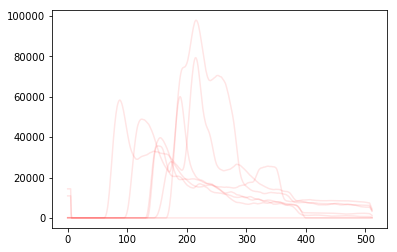

In [58]:
def TriggerFinder(r):
    try:
        trig = status_df.ix[r['EventID']]['trigger']
        thre = 7000
        width = 20
        s,e = int(trig-width),int(trig+width)
        func = interp1d(range(s,e), r.iloc[s+1:e+1].values-thre, kind='cubic')
        return newton(func,trig)
    except:
        print "something is wrong",int(r['EventID'])
        plt.plot(r.iloc[1:].values,c=(1,0,0,0.1))
        #return np.nan
    #plt.figure()
    #plt.plot(range(s,e),r.iloc[int(trig-width+1):int(trig+width+1)].values,c='r')
    #plt.plot(range(s,e),func(range(s,e)),c='b')
    
mask = (status_df['trigger']>350)&(status_df['trigger']<400)
    
Trigger_df = convol_df[mask].iloc[:].apply(TriggerFinder,axis=1)



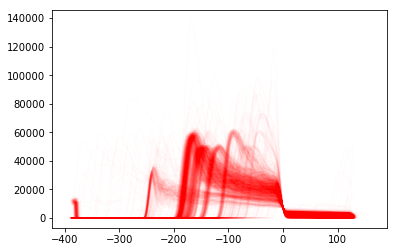

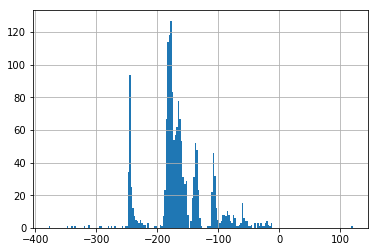

In [110]:
%matplotlib inline
def Process(r):
    x = np.arange(512) - Trigger_df.ix[r['EventID']]
    y = r.iloc[1:].values
    
    grad = np.gradient(y)
    ax = np.argmax(grad)
    plt.plot(x,y, c=(1,0,0,0.01))
    return x[ax]
    #plt.plot(x,y, c=(1,0,0,0.1))

Time_df = convol_df.ix[Trigger_df[~(Trigger_df.isnull())].index].apply(Process,axis=1);
plt.figure()
Time_df.hist(bins=200)
#plt.xlim(-10,10)
#plt.ylim(-10,10000)

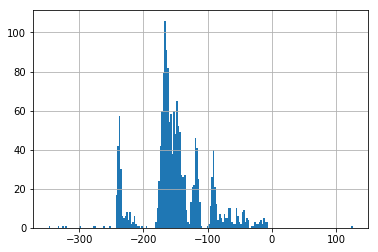

In [108]:
%matplotlib inline
def Process(r):
    x = np.arange(512) - Trigger_df.ix[r['EventID']]
    y = r.iloc[1:].values
    
    ax = np.argmax(y)
    
    return x[ax]
    #plt.plot(x,y, c=(1,0,0,0.1))

Time1_df = convol_df.ix[Trigger_df[~(Trigger_df.isnull())].index].apply(Process,axis=1);
Time1_df.hist(bins=200)

<IPython.core.display.Javascript object>


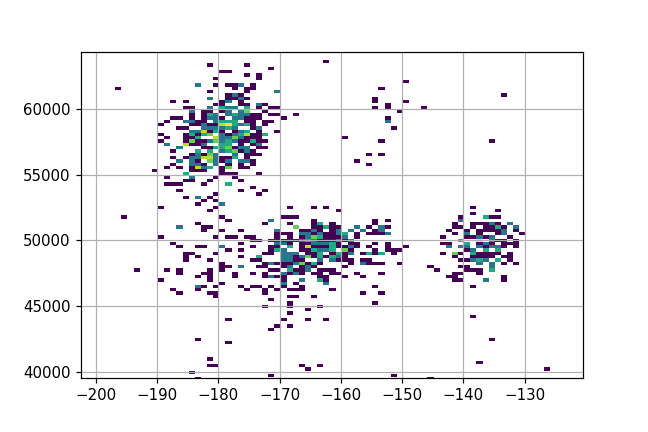

In [103]:
%matplotlib notebook
Heights_df = convol_df.ix[Trigger_df[~(Trigger_df.isnull())].index].max(axis=1)
plt.hist2d(Time_df.values,Heights_df.values,bins=500,norm=LogNorm());

In [46]:
457/368.0

1.2418478260869565